# Modified Trainer that trains only D

In [20]:
import time

from absl import logging
from ddsp.training import train_util
import gin
import tensorflow.compat.v2 as tf
from ddsp.losses import mean_difference


class Trainer(object):
    """Class to bind an optimizer, model, strategy, and training step function."""

    def __init__(self,
                 model,
                 strategy,
                 checkpoints_to_keep=100,
                 learning_rate=0.001,
                 lr_decay_steps=10000,
                 lr_decay_rate=0.98,
                 grad_clip_norm=3.0,
                 restore_keys=None):
        """Constructor.

        Args:
            model: Model to train.
            strategy: A distribution strategy.
            checkpoints_to_keep: Max number of checkpoints before deleting oldest.
            learning_rate: Scalar initial learning rate.
            lr_decay_steps: Exponential decay timescale.
            lr_decay_rate: Exponential decay magnitude.
            grad_clip_norm: Norm level by which to clip gradients.
            restore_keys: List of names of model properties to restore. If no keys are
                passed, restore the whole model.
        """
        self.model = model
        self.strategy = strategy
        self.checkpoints_to_keep = checkpoints_to_keep
        self.grad_clip_norm = grad_clip_norm
        self.restore_keys = restore_keys

        # Create an optimizer.
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=learning_rate,
                decay_steps=lr_decay_steps,
                decay_rate=lr_decay_rate)

        if self.model.is_gan:
            d_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=0.0001,
                    decay_steps=lr_decay_steps,
                    decay_rate=lr_decay_rate) # TODO correct learning schedule + optimizer?

        with self.strategy.scope():
            optimizer = tf.keras.optimizers.Adam(lr_schedule)
            self.optimizer = optimizer
            if self.model.is_gan:
                d_optimizer = tf.keras.optimizers.Adam(d_lr_schedule)
                self.d_optimizer = d_optimizer


    def save(self, save_dir):
        """Saves model and optimizer to a checkpoint."""
        # Saving weights in checkpoint format because saved_model requires
        # handling variable batch size, which some synths and effects can't.
        start_time = time.time()
        checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)
        manager = tf.train.CheckpointManager(
                checkpoint, directory=save_dir, max_to_keep=self.checkpoints_to_keep)
        step = self.step.numpy()
        manager.save(checkpoint_number=step)
        logging.info('Saved checkpoint to %s at step %s', save_dir, step)
        logging.info('Saving model took %.1f seconds', time.time() - start_time)

    def restore(self, checkpoint_path, restore_keys=None):
        """Restore model and optimizer from a checkpoint if it exists."""
        logging.info('Restoring from checkpoint...')
        start_time = time.time()

        # Prefer function args over object properties.
        restore_keys = self.restore_keys if restore_keys is None else restore_keys
        if restore_keys is None:
            # If no keys are passed, restore the whole model.
            model = self.model
            logging.info('Trainer restoring the full model')
        else:
            # Restore only sub-modules by building a new subgraph.
            restore_dict = {k: getattr(self.model, k) for k in restore_keys}
            model = tf.train.Checkpoint(**restore_dict)

            logging.info('Trainer restoring model subcomponents:')
            for k, v in restore_dict.items():
                log_str = 'Restoring {}: {}'.format(k, v)
                logging.info(log_str)

        # Restore from latest checkpoint.
        checkpoint = tf.train.Checkpoint(model=model, optimizer=self.optimizer)
        latest_checkpoint = train_util.get_latest_chekpoint(checkpoint_path)
        if latest_checkpoint is not None:
            # checkpoint.restore must be within a strategy.scope() so that optimizer
            # slot variables are mirrored.
            with self.strategy.scope():
                if restore_keys is None:
                    checkpoint.restore(latest_checkpoint)
                else:
                    checkpoint.restore(latest_checkpoint).expect_partial()
                logging.info('Loaded checkpoint %s', latest_checkpoint)
            logging.info('Loading model took %.1f seconds', time.time() - start_time)
        else:
            logging.info('No checkpoint, skipping.')

    @property
    def step(self):
        """The number of training steps completed."""
        return self.optimizer.iterations

    def psum(self, x, axis=None):
        """Sum across processors."""
        return self.strategy.reduce(tf.distribute.ReduceOp.SUM, x, axis=axis)

    def run(self, fn, *args, **kwargs):
        """Distribute and run function on processors."""
        return self.strategy.run(fn, args=args, kwargs=kwargs)

    def build(self, batch):
        """Build the model by running a distributed batch through it."""
        logging.info('Building the model...')
        _ = self.run(self.model.__call__, batch)
        self.model.summary()

    def distribute_dataset(self, dataset):
        """Create a distributed dataset."""
        if isinstance(dataset, tf.data.Dataset):
            return self.strategy.experimental_distribute_dataset(dataset)
        else:
            return dataset

    @tf.function
    def train_step(self, inputs):
        """Distributed training step."""
        # Wrap iterator in tf.function, slight speedup passing in iter vs batch.
        batch = next(inputs) if hasattr(inputs, '__next__') else inputs
        losses = self.run(self.step_fn, batch)
        # Add up the scalar losses across replicas.
        n_replicas = self.strategy.num_replicas_in_sync
        return {k: self.psum(v, axis=None) / n_replicas for k, v in losses.items()}
    
    @tf.function
    def discriminator_step_fn(self, batch):
        """At this point, the batch already contains the generator output.
        The samples in batch['audio'] and batch['audio_synth'] correspond to each other.
        In order to prevent overfitting on a pattern that is realistic by itself but 
        different from the original sample, it is randomly sampled wether to use the 
        original or synthesized version of a sample.
        """
        losses = {}
        
        real_batch = dict(**batch)
        real_batch['discriminator_audio'] = real_batch['audio']
        fake_batch = dict(**batch)
        fake_batch['discriminator_audio'] = real_batch['audio_synth']
        
        with tf.GradientTape() as tape:
            scores_real = self.model.discriminator(real_batch)['score']
            scores_fake = self.model.discriminator(fake_batch)['score']
            losses['discriminator_loss_real'] = mean_difference(tf.ones_like(scores_real), scores_real, 'L2')
            losses['discriminator_loss_fake'] = mean_difference(-tf.ones_like(scores_fake), scores_fake, 'L2')
            losses['discriminator_loss_total'] = losses['discriminator_loss_real'] + losses['discriminator_loss_fake']
            losses['discriminator_pred_real'] = tf.reduce_mean(scores_real)
            losses['discriminator_pred_fake'] = tf.reduce_mean(scores_fake)
            grads = tape.gradient(losses['discriminator_loss_total'], self.model.discriminator_variables)
        
        return losses, grads
    
    @tf.function
    def step_fn(self, batch):
        """
        Train only the discriminator
        Per-Replica training step."""
        outputs = self.model(batch)
        d_losses, grads = self.discriminator_step_fn(outputs)
        grads, _ = tf.clip_by_global_norm(grads, self.grad_clip_norm)
        self.d_optimizer.apply_gradients(zip(grads, self.model.discriminator_variables))
        return d_losses

# Discriminator tests and debugging

Todo:
- Train d to classify a dataset of only two samples to see that there is a gradient


False
audio (16, 64000)
f0_confidence (16, 1000)
f0_hz (16, 1000)
loudness_db (16, 1000)


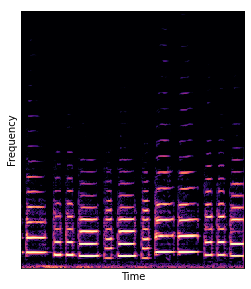

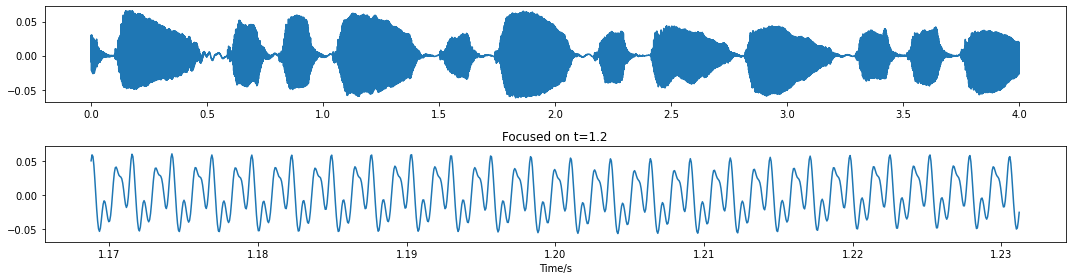

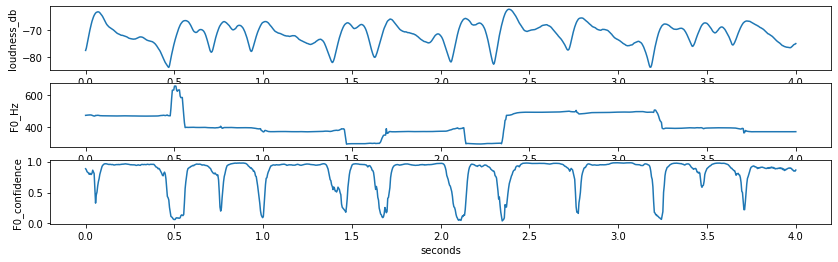

In [2]:
%load_ext autoreload
%autoreload 2

from ddsp.colab import jupyter_utils
import ddsp.training
from matplotlib import pyplot as plt
import numpy as np
import os

TRAIN_TFRECORD_FILEPATTERN = os.environ.get("URMP_MONO")
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
print(data_provider is ddsp.training.data.DataProvider)
dataset = data_provider.get_batch(16)

for i in iter(dataset):
    for k, v in i.items():
        print(k, v.shape)
    break

try:
    ex = next(iter(dataset))
except StopIteration:
    raise ValueError(
        'TFRecord contains no examples. Please try re-running the pipeline with '
        'different audio file(s).')

ex = next(iter(dataset))
jupyter_utils.show_audio(ex['audio'][0])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'][0])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')

ax[1].plot(x, ex['f0_hz'][0])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'][0])

In [21]:
%reload_ext tensorboard
import tensorboard as tb
import warnings
warnings.filterwarnings("ignore")

import time

import ddsp
from ddsp.training import (data, decoders, encoders, models, preprocessing, 
                                                     train_util, discriminator)
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds


SAVE_DIR = "artifacts/tmp"

# tb.notebook.start('--logdir "{}"'.format(SAVE_DIR))

gin.enter_interactive_mode()

sample_rate = 16000
n_samples = 4*sample_rate

strategy = train_util.get_strategy()

with strategy.scope():
    TIME_STEPS = 1000

    # Create Neural Networks.
    preprocessor = preprocessing.F0LoudnessPreprocessor(time_steps=TIME_STEPS)

    decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                    rnn_type = 'gru',
                                    ch = 256,
                                    layers_per_stack = 1,
                                    input_keys = ('ld_scaled', 'f0_scaled', 'z'),
                                    output_splits = (('amps', 1),
                                                    ('harmonic_distribution', 45),
                                                    ('noise_magnitudes', 45)))

    # Create Processors.
    harmonic = ddsp.synths.Harmonic(n_samples=n_samples, 
                                    sample_rate=sample_rate,
                                    name='harmonic')

    noise = ddsp.synths.FilteredNoise(window_size=0,
                                    initial_bias=-10.0,
                                    name='noise')
    add = ddsp.processors.Add(name='add')

    # Create ProcessorGroup.
    dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
            (noise, ['noise_magnitudes']),
            (add, ['noise/signal', 'harmonic/signal'])]

    processor_group = ddsp.processors.ProcessorGroup(dag=dag, name='processor_group')

    encoder = encoders.MfccTimeConstantRnnEncoder(rnn_channels = 512, rnn_type = 'gru', z_dims = 16, z_time_steps = 125)

    critic = discriminator.ParallelWaveGANDiscriminator(input_keys=['discriminator_audio', 'f0_hz', 'loudness_db'])
    model = models.Autoencoder(preprocessor=preprocessor,
                                encoder=encoder,
                                decoder=decoder,
                                processor_group=processor_group,
                                discriminator=critic,
                                losses=[])
    trainer = Trainer(model, strategy, learning_rate=1e-3)
    dataset = trainer.distribute_dataset(dataset)
    trainer.build(next(iter(dataset)))
    print("yo")
    dataset_iter = iter(dataset)
    
    fixed_batch = next(dataset_iter)
    initial_weights_d = [i.numpy() for i in critic.trainable_variables]
    initial_weights_g = [i.numpy() for i in model.generator_variables]

for i in range(5):
    losses = trainer.train_step(dataset_iter)
    updated_weights_d = [i.numpy() for i in critic.trainable_variables]
    updated_weights_g = [i.numpy() for i in model.generator_variables]
    res_str = 'step: {}\t'.format(i)
    for k, v in losses.items():
            res_str += '{}: {:.2f}\t'.format(k, v)
    print(res_str)

    if i % 300 == 1:
        print(f"Step {i}")
        trainer.save(SAVE_DIR)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Model: "autoencoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
f0_loudness_preprocessor_4 ( multiple                  0         
_________________________________________________________________
mfcc_time_constant_rnn_encod multiple                  844365    
_________________________________________________________________
rnn_fc_decoder_4 (RnnFcDecod multiple                  1081179   
_________________________________________________________________
processor_group (ProcessorGr multiple                  0         
_________________________________________________________________
parallel_wave_gan_discrimina multiple                  199690    
Total params: 2,125,234
Trainable params: 2,025,769
Non-trainable params: 99,465
_________________________________________________________________
yo
INFO:tensorflow:batch_all_reduce: 29 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 29 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 29 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 29 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


step: 0	discriminator_loss_real: 1.26	discriminator_loss_fake: 5.79	discriminator_loss_total: 7.05	discriminator_pred_real: 1.13	discriminator_pred_fake: 1.13	
step: 1	discriminator_loss_real: 0.81	discriminator_loss_fake: 5.00	discriminator_loss_total: 5.81	discriminator_pred_real: 1.05	discriminator_pred_fake: 1.05	
Step 1
step: 2	discriminator_loss_real: 0.53	discriminator_loss_fake: 4.12	discriminator_loss_total: 4.65	discriminator_pred_real: 0.90	discriminator_pred_fake: 0.90	
step: 3	discriminator_loss_real: 0.53	discriminator_loss_fake: 3.16	discriminator_loss_total: 3.68	discriminator_pred_real: 0.66	discriminator_pred_fake: 0.66	
step: 4	discriminator_loss_real: 0.58	discriminator_loss_fake: 2.45	discriminator_loss_total: 3.04	discriminator_pred_real: 0.47	discriminator_pred_fake: 0.47	


In [22]:
[i-j for i,j in zip(initial_weights_d, updated_weights_d)]

[array([ 0.96878016, -2.1990738 ,  0.9842043 ,  0.74698687,  0.9764698 ,
         0.9754175 ,  0.87923455,  0.9387717 ,  0.9810218 ,  0.9831061 ,
         0.9846367 ,  0.9528787 ,  0.9821574 ,  0.90358424,  0.98487055,
         0.9724516 ,  0.9677781 ,  0.97645307,  0.9237573 ,  0.9785656 ,
         0.9508651 ,  0.9792693 ,  0.94465125,  0.9833685 ,  0.9262611 ,
         0.98750585,  0.74973494,  0.97907597,  0.9845531 ,  0.9706554 ,
         0.9855924 ,  0.96816176,  0.9741676 ,  0.9468292 ,  0.9725161 ,
         0.9321486 ,  0.94445837,  0.9872657 ,  0.16347533,  0.9501206 ,
         0.90742403,  0.95919573,  0.93869483,  0.9432901 ,  0.88444304,
         0.98139924,  0.97338426,  0.91430503,  0.93442976,  0.9746524 ,
         0.9740934 ,  0.80964106,  0.82934326,  0.9606351 ,  0.93219554,
         0.98842245,  0.98647463,  0.8435831 ,  0.8526778 , -2.1812243 ,
         0.9050491 ,  0.9750642 ,  0.93470454,  0.95561564], dtype=float32),
 array([[[ 8.70451331e-05, -2.97520310e-04,  1.

In [ ]:
for i in range(100):
    losses = trainer.train_step(dataset_iter)
    updated_weights_d = [i.numpy() for i in critic.trainable_variables]
    updated_weights_g = [i.numpy() for i in model.generator_variables]
    res_str = 'step: {}\t'.format(i)
    for k, v in losses.items():
            res_str += '{}: {:.2f}\t'.format(k, v)
    print(res_str)

step: 0	discriminator_loss_real: 0.51	discriminator_loss_fake: 2.18	discriminator_loss_total: 2.69	discriminator_pred_real: 0.42	discriminator_pred_fake: 0.42	
step: 1	discriminator_loss_real: 0.63	discriminator_loss_fake: 1.72	discriminator_loss_total: 2.35	discriminator_pred_real: 0.27	discriminator_pred_fake: 0.27	
step: 2	discriminator_loss_real: 0.69	discriminator_loss_fake: 1.43	discriminator_loss_total: 2.12	discriminator_pred_real: 0.19	discriminator_pred_fake: 0.19	
step: 3	discriminator_loss_real: 0.85	discriminator_loss_fake: 1.18	discriminator_loss_total: 2.04	discriminator_pred_real: 0.08	discriminator_pred_fake: 0.08	
step: 4	discriminator_loss_real: 1.18	discriminator_loss_fake: 0.88	discriminator_loss_total: 2.05	discriminator_pred_real: -0.07	discriminator_pred_fake: -0.07	
step: 5	discriminator_loss_real: 1.27	discriminator_loss_fake: 0.81	discriminator_loss_total: 2.08	discriminator_pred_real: -0.12	discriminator_pred_fake: -0.12	
step: 6	discriminator_loss_real: 1.3

In [ ]:
# def random_noise():
#     return {
#         "f0_hz": np.random.normal
#     }

In [11]:
outputs = model(ex)

In [19]:
critic = discriminator.ParallelWaveGANDiscriminator(input_keys=['discriminator_audio', 'f0_hz', 'loudness_db'])

real = dict(**outputs)
real['discriminator_audio'] = real['audio']
score_real = critic(real)

fake = dict(**outputs)
fake['discriminator_audio'] = real['audio_synth']
score_fake = critic(fake)
score_fake

{'score': <tf.Tensor: shape=(16,), dtype=float32, numpy=
 array([-0.06645617, -0.00907318, -0.03439656, -0.02540755, -0.02198879,
        -0.02219413,  0.10043318,  0.07320849, -0.02789523,  0.01715649,
        -0.02635457, -0.07435222,  0.09247959, -0.01358686, -0.09260409,
        -0.11972335], dtype=float32)>}

In [13]:
score_real['score']==score_fake['score']

<tf.Tensor: shape=(16,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])>

In [14]:
test = dict(**outputs)
test['discriminator_audio'] = test['audio_synth']*0
score_test = critic(test)

score_test['score']==score_fake['score']

<tf.Tensor: shape=(16,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])>

In [15]:
score_fake['score'].numpy() - score_real['score'].numpy()

array([-1.3142824e-05, -3.1292439e-05, -6.1392784e-06, -5.1558018e-06,
       -3.7550926e-06, -1.3023615e-05, -1.6689301e-05, -1.7940998e-05,
        8.0466270e-07, -8.1658363e-06, -6.3568354e-05,  6.6757202e-06,
       -5.3346157e-06,  8.3446503e-07,  1.6272068e-05,  1.4811754e-05],
      dtype=float32)

In [16]:
score_fake['score'].numpy()

array([0.47820702, 0.36534688, 0.60997313, 0.37323377, 0.64212334,
       0.4302551 , 0.4660166 , 0.3548955 , 0.44292516, 0.50246805,
       0.36433265, 0.36701378, 0.40276808, 0.48888817, 0.439849  ,
       0.46455997], dtype=float32)